## 1. Setup

In [1]:
import os
import glob
from tqdm import tqdm_notebook as tqdm
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from torch.optim.lr_scheduler import CosineAnnealingLR

import warnings
warnings.filterwarnings("ignore")

In [2]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(2021)

In [3]:
# local notebook settings
# from efficientnet_pytorch_3d import EfficientNet3D
# train_path = 'train_labels.csv'
# test_path = 'sample_submission_csv'
# png_path = 'archive'
# from volumentations import *


# kaggle settings
import sys
sys.path.append('../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D')
from efficientnet_pytorch_3d import EfficientNet3D

sys.path.append('../input/3d-augmentation/volumentations-master')
from volumentations import *

sys.path.append('../input/gradualwarmupschedulerv2')
from warmup_scheduler import GradualWarmupScheduler

train_path = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv'
test_path = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv'
png_path = '../input/rsna-miccai-png'

In [4]:
img_size = 256

## 2. Dataloader

In [5]:
def load_image(scan_id, split='train', path='../input/rsna-miccai-png'):
    flair = sorted(glob.glob(f"{path}/{split}/{scan_id}/FLAIR/*.png"))
    t1w = sorted(glob.glob(f"{path}/{split}/{scan_id}/T1w/*.png"))
    t1wce = sorted(glob.glob(f"{path}/{split}/{scan_id}/T1wCE/*.png"))
    t2w = sorted(glob.glob(f"{path}/{split}/{scan_id}/T2w/*.png"))
    
    write = 0
    
    for i in [flair, t1w, t1wce, t2w]:
        
        if len(i) == 0:
            i_img = np.zeros((img_size, img_size, 50))
        elif len(i) < 50:
            i_img = np.array([cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size, img_size))
                            for path in i[0:50]]).T 
            num_zero = 50 - i_img.shape[-1]
            i_img = np.concatenate((i_img, np.zeros((img_size, img_size, num_zero))), -1)
        else: 
            i_img = np.array([cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size, img_size)) 
                             for path in i[len(i) // 2 - 25: len(i) // 2 + 25]]).T
        
        if write == 0: 
            img = i_img 
            write = 1
        else: 
            img = np.concatenate((img, i_img), axis=-1)
            
    return img

In [6]:
class RSNADataset(Dataset):
    def __init__(self, csv, mode='train', transform=None):
        self.csv = csv
        self.mode = mode
        self.transform = transform
        
    def __len__(self): 
        return self.csv.shape[0]
    
    def __getitem__(self, idx): 
        data = self.csv.iloc[idx]
        brat = str(int(data["BraTS21ID"])).zfill(5)
        mgmt = data['MGMT_value']
        
        image = load_image(brat, self.mode)
        image = image.transpose(2, 0, 1)
        
        if self.transform is not None:
            data = {'image': image}
            aug_data = self.transform(**data)
            image = aug_data['image']
            
        image = image / 255
        
        if self.mode == 'train': 
            return torch.tensor(image, dtype=torch.float32), torch.tensor(mgmt, dtype=torch.long)
        else: 
            return torch.tensor(image, dtype=torch.float32), brat
            

In [7]:
transforms_train = Compose([
        Flip(-1, p=0.5),
        Rotate((-25, 25), (0, 0), (0, 0), p=0.8),
        CenterCrop((200, 240, 240), 0.3),
        ElasticTransformPseudo2D(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.3),
        GaussianNoise(var_limit=(2, 5), mean=3, p=0.3)
    ], p=1)

## 3. Train 

In [8]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [9]:
train_df = pd.read_csv(train_path)
df_train, df_val = model_selection.train_test_split(train_df, test_size=0.2, random_state=2021, stratify=train_df["MGMT_value"])


train_dataset = RSNADataset(df_train, transform=None)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=2, num_workers=8)

val_dataset = RSNADataset(df_val)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=2, num_workers=8)

In [10]:
cosine_epo = 17
warmup_epo = 3
n_epochs = cosine_epo + warmup_epo

model = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

In [11]:
device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

best_train = 10000
best_val = 10000
best_auc = 0

model_train_losses = []
model_val_losses = []
auc_scores = []

for epoch in range(n_epochs): 
    scheduler_warmup.step(epoch)

    train_loss = []
    model.train()
    
    for i, data in tqdm(enumerate(train_loader, 0)): 
        x, y = data
        x = torch.unsqueeze(x, dim=1)
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
    avg_train = sum(train_loss) / len(train_loss)
    model_train_losses.append(avg_train)
    print(f'epoch {epoch + 1} train: {avg_train}')
    
    if avg_train < best_train: 
        print('save train model...')
        best_val = avg_train
        train_model = f'best_train_{epoch + 1}.pt'
        torch.save(model.state_dict(), f'best_train_{epoch + 1}.pt')
    
    
    val_loss = []
    y_all = []
    outputs_all = []
    
    model.eval()
    
    for i, data in tqdm(enumerate(val_loader, 0)): 
        with torch.no_grad():
            x, y = data 
            x = torch.unsqueeze(x, dim=1)
            x, y = x.to(device), y.to(device)
            
            outputs = model(x)
            loss = criterion(outputs, y)
            
            val_loss.append(loss.item())
            y_all.extend(y.tolist())
            outputs_all.extend(outputs.tolist())
    auc = roc_auc_score(y_all, np.array(outputs_all)[:,1])
    auc_scores.append(auc)
    
    avg_val = sum(val_loss) / len(val_loss)
    model_val_losses.append(avg_val)
    print(f'epoch {epoch + 1} val: {avg_val} auc: {auc}')
    
    if auc > best_auc: 
        print('save auc model...')
        best_auc = auc
        auc_model = f'best_auc_{epoch + 1}.pt'
        torch.save(model.state_dict(), f'best_auc_{epoch + 1}.pt')
    
    if avg_val < best_val: 
        print('save val model...')
        best_val = avg_val
        val_model = f'best_val_{epoch + 1}.pt'
        torch.save(model.state_dict(), f'best_val_{epoch + 1}.pt')
    
    print('')
    print('')

0it [00:00, ?it/s]

epoch 1 train: 0.7136988609265058
save train model...


0it [00:00, ?it/s]

epoch 1 val: 0.698517727649818 auc: 0.6132903981264637
save auc model...
save val model...



0it [00:00, ?it/s]

epoch 2 train: 0.7426618485369234


0it [00:00, ?it/s]

epoch 2 val: 0.7490708651178974 auc: 0.4206674473067915



0it [00:00, ?it/s]

epoch 3 train: 0.7283607450051185


0it [00:00, ?it/s]

epoch 3 val: 0.7704883621910871 auc: 0.6015807962529274



0it [00:00, ?it/s]

epoch 4 train: 0.7082986347695701


0it [00:00, ?it/s]

epoch 4 val: 0.6933819045454769 auc: 0.4795081967213115
save val model...



0it [00:00, ?it/s]

epoch 5 train: 0.7039657263164847


0it [00:00, ?it/s]

epoch 5 val: 0.6919586577657926 auc: 0.6721311475409836
save auc model...
save val model...



0it [00:00, ?it/s]

epoch 6 train: 0.7040833825739021


0it [00:00, ?it/s]

epoch 6 val: 0.6981929874016066 auc: 0.6457845433255269



0it [00:00, ?it/s]

epoch 7 train: 0.6950408403690045


0it [00:00, ?it/s]

epoch 7 val: 0.677141589633489 auc: 0.6531030444964872
save val model...



0it [00:00, ?it/s]

epoch 8 train: 0.6969394436758808


0it [00:00, ?it/s]

epoch 8 val: 0.6738732234906342 auc: 0.6648126463700234
save val model...



0it [00:00, ?it/s]

epoch 9 train: 0.6975323648279549


0it [00:00, ?it/s]

epoch 9 val: 0.716369605670541 auc: 0.49033957845433257



0it [00:00, ?it/s]

epoch 10 train: 0.6987030118958563


0it [00:00, ?it/s]

epoch 10 val: 0.6924984828900482 auc: 0.522248243559719



0it [00:00, ?it/s]

epoch 11 train: 0.6969622939060895


0it [00:00, ?it/s]

epoch 11 val: 0.6984370643809691 auc: 0.3430913348946135



0it [00:00, ?it/s]

epoch 12 train: 0.6961247556739383


0it [00:00, ?it/s]

epoch 12 val: 0.6953836982533083 auc: 0.4253512880562061



0it [00:00, ?it/s]

epoch 13 train: 0.6931431876797961


0it [00:00, ?it/s]

epoch 13 val: 0.694593277017949 auc: 0.48653395784543324



0it [00:00, ?it/s]

epoch 14 train: 0.6970729407591697


0it [00:00, ?it/s]

epoch 14 val: 0.6907363493563765 auc: 0.6536885245901639



0it [00:00, ?it/s]

epoch 15 train: 0.6939305579050993


0it [00:00, ?it/s]

epoch 15 val: 0.7183070056519266 auc: 0.3471896955503513



0it [00:00, ?it/s]

epoch 16 train: 0.6910513017931555


0it [00:00, ?it/s]

epoch 16 val: 0.668830394492311 auc: 0.6879391100702577
save auc model...
save val model...



0it [00:00, ?it/s]

epoch 17 train: 0.6912510094479618


0it [00:00, ?it/s]

epoch 17 val: 0.7008530952162662 auc: 0.6492974238875878



0it [00:00, ?it/s]

epoch 18 train: 0.6718305365906821


0it [00:00, ?it/s]

epoch 18 val: 0.666051993430671 auc: 0.6618852459016393
save val model...



0it [00:00, ?it/s]

epoch 19 train: 0.6787435859441757


0it [00:00, ?it/s]

epoch 19 val: 0.662119326955181 auc: 0.6735948477751756
save val model...



0it [00:00, ?it/s]

epoch 20 train: 0.659138592517274
save train model...


0it [00:00, ?it/s]

epoch 20 val: 0.6670848429203033 auc: 0.6727166276346604



## 4. Predict

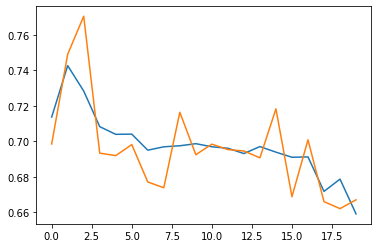

In [17]:
# plt.plot(model_train_losses)
# plt.plot(model_val_losses)
# plt.show()

In [20]:
device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')
model_name = '../input/best-loss-version5/best_val_7.pt'
model = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
model.to(device)
checkpoint = torch.load(model_name)
model.load_state_dict(checkpoint)
model.eval()

EfficientNet3D(
  (_conv_stem): Conv3dStaticSamePadding(
    1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm3d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock3D(
      (_depthwise_conv): Conv3dStaticSamePadding(
        32, 32, kernel_size=(3, 3, 3), stride=[2, 2, 2], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1, 0, 1), value=0.0)
      )
      (_bn1): BatchNorm3d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv3dStaticSamePadding(
        32, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv3dStaticSamePadding(
        8, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv3dStaticS

In [21]:
df_test = pd.read_csv(test_path)
test_dataset = RSNADataset(df_test, mode="test")
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=8)

In [22]:
y_pred = []
ids = []

for e, batch in enumerate(test_loader):
    print(f"{e + 1}/{len(test_loader)}", end="\r")
    batch, brat = batch
    with torch.no_grad():
        tmp_pred = np.zeros((batch.shape[0], 2))
        tmp_res = torch.sigmoid(model(batch.unsqueeze(1).to(device))).cpu().numpy().squeeze()
        tmp_pred += tmp_res
        y_pred.extend(tmp_pred)
        ids.extend([brat])

## 5. Submit

In [23]:
test = np.array(y_pred)
test_df = pd.DataFrame({"BraTS21ID": df_test['BraTS21ID'].apply(lambda x: str(x).zfill(5)), "MGMT_value": test[:,1]})

In [24]:
test_df.to_csv("submission.csv", index=False)

In [ ]:
# Done:
# have a val, and then using roc_auc_score
# todo: data augmentation
# schedule lr
# try different effnet model
#resize 512

# To-do:
# I don't think it will be a good approach however I have one recommendation, try training two cnns of same mri type and ensemble them.
# Mostly it will be one 3d cnn and one 2d cnn.
# T2w images will also work well along with FLAIR images
# see the previous competition's top solution

# compute sigmoid before auc

# best version: '../input/best-loss-version5/best_val_18.pt'